# Establishing a threshold

## Setup


In [1]:
import os
import pandas as pd

from nutritionrag.rag_pipeline import rag_setup_qdrant, query_vector_db_list_qdrant, rag_query_list_qdrant

/home/szaboildi/code/szaboildi/nutrition-rag/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%cd ../..

/home/szaboildi/code/szaboildi/nutrition-rag


/home/szaboildi/code/szaboildi/nutrition-rag/.venv/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [3]:
try:
    import tomllib # type: ignore
except ModuleNotFoundError:
    import tomli as tomllib

with open(os.path.join("parameters.toml"), mode="rb") as fp:
    config = tomllib.load(fp)

config_name = "default"
from_scratch = False

In [4]:
eval_df = pd.read_csv(os.path.join("data", "eval", "test_questions_raw.csv"))
query_list = eval_df["user_question"].to_list()

In [5]:
# Setup
# vector_db_client, encoder = setup_vector_db(
#     encoder_name=config[config_name]["encoder_name"],
#     client_source=config[config_name]["client_source"],
#     qdrant_cloud_api_key=os.environ.get("QDRANT_CLOUD_API_KEY"),
#     from_scratch=from_scratch,
#     input_folder=config[config_name]["input_text_folder"],
#     collection_name=config[config_name]["collection_name"],
#     dist_name=config[config_name]["distance_type"],
#     input_folder_qa=config[config_name]["input_folder_qa"]
# )

vector_db_client, encoder, llm_client = rag_setup_qdrant(
    config=config[config_name], from_scratch=from_scratch)

Vector database loaded
RAG setup complete


## Retrieval

In [6]:
raw_answers = query_vector_db_list_qdrant(
    vector_db_client, encoder, query_list,
    collection_name=config[config_name]["collection_name"],
    # k=config[config_name]["retrieve_k"]
    k=10)

In [ ]:
# Data formatting
processed_answers = []

# unpack the payloads into a single dataframe
for i in range(len(raw_answers)):
    for doc in raw_answers[i]["retrieved"]:
        processed_answers.append(
            {"user_question": raw_answers[i]["user_question"],
            **doc})

processed_answers = pd.DataFrame(processed_answers).merge(eval_df, how="inner")
processed_answers_grouped = processed_answers.groupby(["user_question", "answerable"]).agg({"cosine": ["min", "max"]}).reset_index()
processed_answers_grouped.columns = ["user_question", "answerable", "min_cosine", "max_cosine"]

In [8]:
# processed_answers.loc[~(processed_answers.answerable)]

In [ ]:
processed_answers_grouped

,user_question,answerable,min_cosine,max_cosine
0,Are any foods no-go for someone with diabetes?,True,0.888712,0.930672
1,"As a diabetic, should I choose an apple or a c...",True,0.848290,0.882059
2,"As a diabetic, should I skip either lunch or d...",True,0.880976,0.947247
3,"Can I drink a caramel cappuccino, if I have di...",True,0.852998,0.884836
4,Can I eat white bread as a diabetic?,True,0.859596,0.885423
5,Can you eat berries with diabetes?,True,0.856233,0.927814
6,Can you eat pineapple with diabetes?,True,0.846195,0.897337
7,I'm considering intermittent fasting. Could it...,True,0.861049,0.919834
8,Is it better to have a high blood sugar or a l...,True,0.864648,0.911115
9,Should I not eat carbohydrates at all as a dia...,True,0.889108,0.948491


/home/szaboildi/code/szaboildi/nutrition-rag/.venv/bin/python: No module named pip


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Note: you may need to restart the kernel to use updated packages.


<Axes: ylabel='max_cosine'>

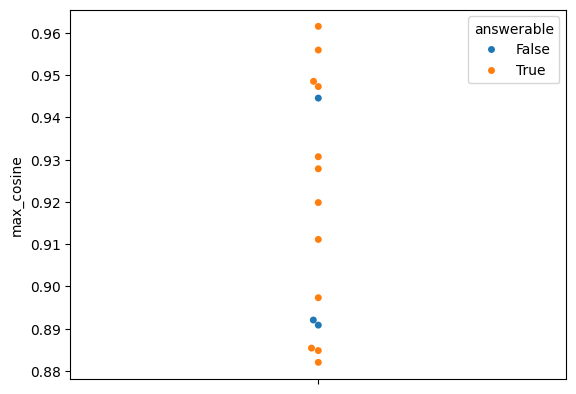

In [14]:
%pip install seaborn
import seaborn as sns


sns.swarmplot(data=processed_answers_grouped, y="max_cosine", hue="answerable")

## RAG

In [16]:
rag_responses = rag_query_list_qdrant(
    query_list, vector_db_client, encoder, llm_client, config[config_name])

Documents retrieved
Documents retrieved
Documents retrieved
Documents retrieved
Documents retrieved
Documents retrieved
Documents retrieved
Documents retrieved
Documents retrieved
Documents retrieved
Documents retrieved
Documents retrieved
Documents retrieved
Documents retrieved
Documents retrieved


In [11]:
qa_df = pd.DataFrame({"user_question": rag_responses[0], "llm_response": rag_responses[1]})
qa_df_meta = pd.DataFrame([{**item, "user_question": row["user_question"]} for row in rag_responses[2] for item in row["retrieved"]])

rag_df_processed = qa_df.merge(qa_df_meta, how="inner")

In [12]:
rag_df_processed

,user_question,llm_response,question,answer,cosine
0,Are any foods no-go for someone with diabetes?,"Avoid sugary drinks, processed snacks, white b...",Are there any foods I should stay away from wi...,"Avoid sugary drinks, processed snacks, white b...",0.930672
1,Are any foods no-go for someone with diabetes?,"Avoid sugary drinks, processed snacks, white b...",What are some unhealthy foods for people with ...,"Avoid sugary drinks, processed snacks, white b...",0.929724
2,Are any foods no-go for someone with diabetes?,"Avoid sugary drinks, processed snacks, white b...",What should diabetics not eat?,"Avoid sugary drinks, processed snacks, white b...",0.923179
3,Are any foods no-go for someone with diabetes?,"Avoid sugary drinks, processed snacks, white b...",What foods should I avoid as a diabetic?,"Avoid sugary drinks, processed snacks, white b...",0.920402
4,Are any foods no-go for someone with diabetes?,"Avoid sugary drinks, processed snacks, white b...",Are there low-sugar snacks that are good for p...,"Healthy snack options include Greek yogurt, al...",0.905660
...,...,...,...,...,...
70,Should I not eat carbohydrates at all as a dia...,"Yes, but focus on complex carbs like whole gra...",Should I avoid all carbs with diabetes?,"Yes, but focus on complex carbs like whole gra...",0.948491
71,Should I not eat carbohydrates at all as a dia...,"Yes, but focus on complex carbs like whole gra...",Can I eat carbs if I have diabetes?,"Yes, but focus on complex carbs like whole gra...",0.929237
72,Should I not eat carbohydrates at all as a dia...,"Yes, but focus on complex carbs like whole gra...",Are carbohydrates bad for diabetics?,"Yes, but focus on complex carbs like whole gra...",0.923894
73,Should I not eat carbohydrates at all as a dia...,"Yes, but focus on complex carbs like whole gra...",What should diabetics not eat?,"Avoid sugary drinks, processed snacks, white b...",0.905080


In [13]:
rag_df_processed[["user_question", "llm_response"]].drop_duplicates().apply(lambda x: print(x.user_question, x.llm_response), axis=1)

Are any foods no-go for someone with diabetes? Avoid sugary drinks, processed snacks, white bread, and high-sugar desserts.
Can you eat berries with diabetes? Yes, you can eat berries with diabetes. They are a good option due to their fiber content. Just watch portion sizes.
Can you eat pineapple with diabetes? Sorry, I donʼt have information on that. Please try a different question.
Can I eat white bread as a diabetic? Sorry, I donʼt have information on that. Please try a different question.
What's a good lunch for someone with diabetes? Sorry, I donʼt have information on that. Please try a different question.
Can I drink a caramel cappuccino, if I have diabetes? Sorry, I donʼt have information on that. Please try a different question.
I'm considering intermittent fasting. Could it help me maintain my blood sugar? It depends on the individual and medication. Always consult a healthcare provider before starting any fasting regimen.
What's your favorite snack? Sorry, I donʼt have inform

0     None
5     None
10    None
15    None
20    None
25    None
30    None
35    None
40    None
45    None
50    None
55    None
60    None
65    None
70    None
dtype: object